In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

In [78]:
train_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
valid_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


Question 1. Number of columns?


In [54]:
train_df.shape[1]

19

Question 2. Duration of trips (std)

In [55]:
train_df['duration'] = (((train_df.tpep_dropoff_datetime - train_df.tpep_pickup_datetime).apply(lambda x: x.seconds)) / 60).astype('float32')

In [56]:
train_df.duration.std(axis=0)

41.36931228637695

<Axes: xlabel='duration', ylabel='Density'>

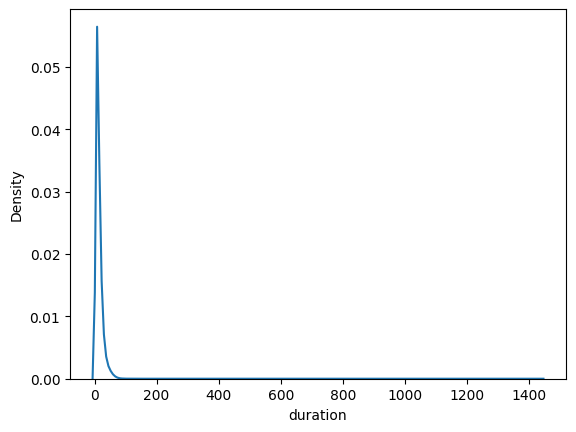

In [57]:
sns.kdeplot(train_df.duration)

In [58]:
train_df.duration.min(), train_df.duration.max()

(0.0, 1439.800048828125)

In [59]:
train = train_df[(train_df['duration'] >= 1) & (train_df['duration'] <= 60)]
train.shape

(3009176, 20)

Question 4. fraction of the records left after you dropped the outliers?

In [60]:
ans = (train.shape[0]/train_df.shape[0])*100
ans

98.12212604417813

In [61]:
cols = ['PULocationID', 'DOLocationID']
target = ['duration']

In [62]:
X_train = train[cols].astype('str')

In [63]:
X_train.dtypes

,0
PULocationID,object
DOLocationID,object


In [64]:
train_dict = X_train.to_dict(orient='records')

In [65]:
dv = DictVectorizer()

In [66]:
feature_matrix = dv.fit_transform(train_dict)

Question 4. dimenionality of sparse matrix?

In [67]:
feature_matrix.shape[1]

515

In [68]:
model = LinearRegression()
model.fit(feature_matrix, train.duration)

LinearRegression()

In [69]:
train_preds = model.predict(feature_matrix)

In [70]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

Question 5. RMSE on training data

In [71]:
train_error = rmse(train_preds, train.duration)
train_error

np.float64(7.649261351835341)

In [79]:
valid_df['duration'] = (((valid_df.tpep_dropoff_datetime - valid_df.tpep_pickup_datetime).apply(lambda x: x.seconds)) / 60).astype('float32')
valid_df = valid_df[(valid_df['duration'] >= 1) & (valid_df['duration'] <= 60)]

In [80]:
valid = valid_df[cols].astype('str')
valid_dict = valid.to_dict(orient='records')

Question 6. validation RMSE?

In [81]:
valid_matrix = dv.transform(valid_dict)

In [82]:
valid_preds = model.predict(valid_matrix)
valid_preds

array([11.36780576, 49.69416089, 15.19120797, ..., 13.5332447 ,
       11.09570888, 13.15700556])

In [84]:
valid_error = rmse(valid_df.duration, valid_preds)
valid_error

np.float64(7.811816060276207)